**TP qu'on va utiliser finale a copier sur Github**

**Projet**

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import MissingIndicator, KNNImputer,SimpleImputer
from sklearn.impute import IterativeImputer
import seaborn as sns


df = pd.read_csv('framingham.csv')

In [2]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


**On va commencer par le pre-processing de notre dataset**

In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4238 entries, 0 to 4237
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4238 non-null   int64  
 1   age              4238 non-null   int64  
 2   education        4133 non-null   float64
 3   currentSmoker    4238 non-null   int64  
 4   cigsPerDay       4209 non-null   float64
 5   BPMeds           4185 non-null   float64
 6   prevalentStroke  4238 non-null   int64  
 7   prevalentHyp     4238 non-null   int64  
 8   diabetes         4238 non-null   int64  
 9   totChol          4188 non-null   float64
 10  sysBP            4238 non-null   float64
 11  diaBP            4238 non-null   float64
 12  BMI              4219 non-null   float64
 13  heartRate        4237 non-null   float64
 14  glucose          3850 non-null   float64
 15  TenYearCHD       4238 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.9 KB


**Identification des valeurs abberantes**

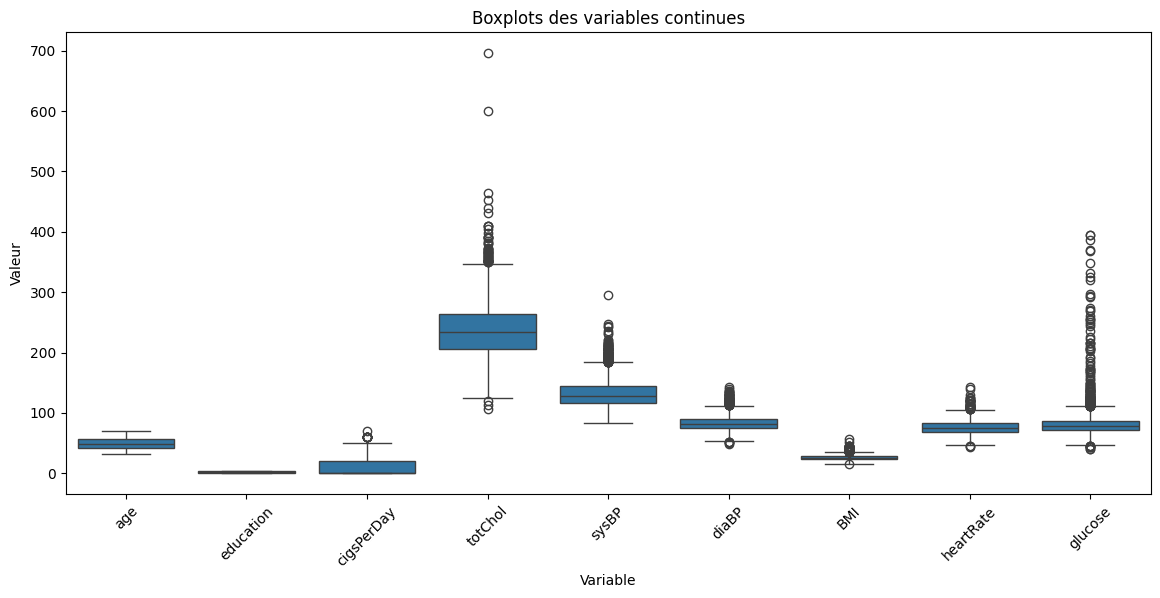

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt


columns =['age', 'education', 'cigsPerDay', 'totChol', 'sysBP','diaBP', 'BMI', 'heartRate', 'glucose']
df_melted = df[columns].melt(var_name='Variable', value_name='Valeur')
# Création des boxplots pour toutes les variables continues
plt.figure(figsize=(14, 6))  # Ajustez la taille selon vos besoins
sns.boxplot(data=df_melted, x='Variable', y='Valeur')
plt.xticks(rotation=45)  # Rotation des labels pour lisibilité
plt.title("Boxplots des variables continues")
plt.show()

**Pour la variable education**

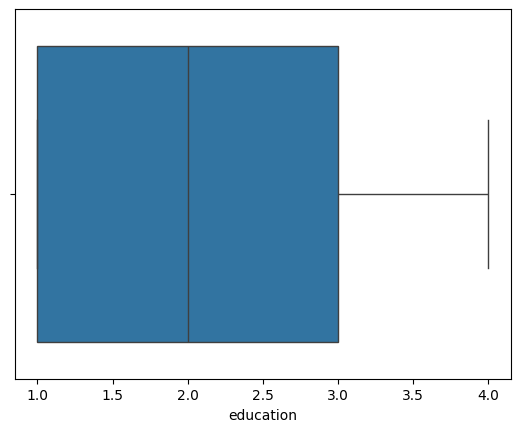

In [5]:
sns.boxplot(data=df, x='education')
plt.show()

**La variable education ne contient aucune valeur aberrante**

**La variable age**

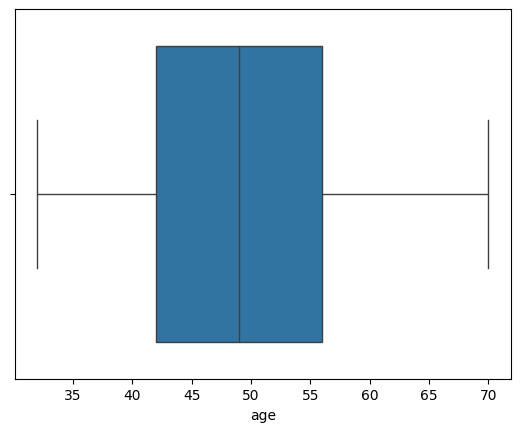

In [6]:
sns.boxplot(data=df, x='age')
plt.show()

**La variable age ne contient aucune valeur aberrante**

**La variable cigsPerday**

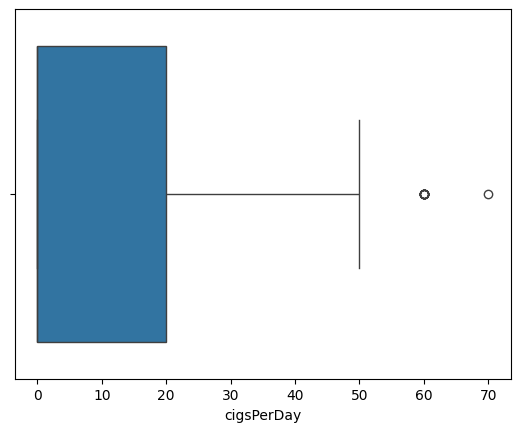

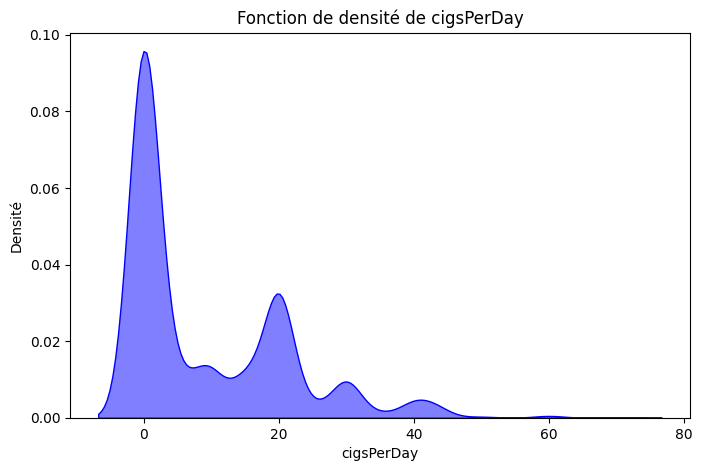

In [7]:
sns.boxplot(data=df, x='cigsPerDay')
variable ='cigsPerDay' 
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x=variable, fill=True, color='blue', alpha=0.5)
plt.title(f"Fonction de densité de {variable}")
plt.xlabel(variable)
plt.ylabel("Densité")
plt.show()


**Il faut se débarasser des outliers pour cette variable**

In [8]:
# Identification des données aberrantes - IQR
# Fonction pour détecter les outliers en utilisant l'IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Trouver les outliers pour la colonne 'PRICE'
outliers = detect_outliers_iqr(df,'cigsPerDay')
# Afficher les outliers
print("Outliers détectés:")
print(outliers)
print(len(outliers))

Outliers détectés:
      male  age  education  currentSmoker  cigsPerDay  BPMeds  \
327      1   56        1.0              1        60.0     0.0   
721      1   59        1.0              1        60.0     0.0   
1054     1   58        2.0              1        60.0     0.0   
1452     1   39        1.0              1        60.0     0.0   
1468     1   50        1.0              1        60.0     0.0   
1488     1   37        4.0              1        60.0     0.0   
1849     1   48        1.0              1        60.0     0.0   
2709     1   46        1.0              1        60.0     0.0   
2710     1   49        2.0              1        60.0     0.0   
3008     1   40        3.0              1        70.0     0.0   
3673     1   48        NaN              1        60.0     0.0   
3928     1   67        2.0              1        60.0     0.0   

      prevalentStroke  prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  \
327                 0             0         0    246.0  

**On remarque que cette variable contient 12 valeurs aberrntes egale a 60,70 cigarettes per day chose illogique qui peut etre due a une faute de frappe donc on va essayer de remplacer ces valeurs pour la moyenne au lieu de les supprimer**

In [9]:
def replace_outliers_with_mean(data, column):
    # Calcul des quartiles et des bornes
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Calcul de la moyenne de la colonne (sans tenir compte des NaN)
    column_mean = data[column].mean()
    
    # Remplacement des valeurs aberrantes
    data[column] = data[column].apply(lambda x: column_mean if (x < lower_bound or x > upper_bound) else x)
    return data

# Application de la fonction à la colonne 'cigsPerDay'
df = replace_outliers_with_mean(df, 'cigsPerDay')

# Vérification
print("Colonnes après traitement des outliers :")
print(df['cigsPerDay'].describe())


Colonnes après traitement des outliers :
count    4209.000000
mean        8.855319
std        11.592422
min         0.000000
25%         0.000000
50%         0.000000
75%        20.000000
max        50.000000
Name: cigsPerDay, dtype: float64


<Axes: xlabel='cigsPerDay'>

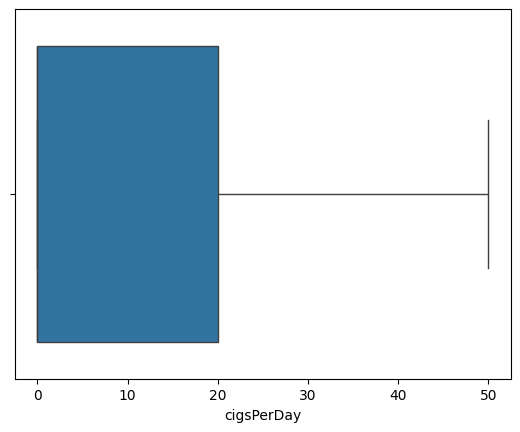

In [10]:
sns.boxplot(data=df, x='cigsPerDay')


**Maintenat on a pas de valeurs abberantes pour CIgsPerDay**

**La variable totchol**

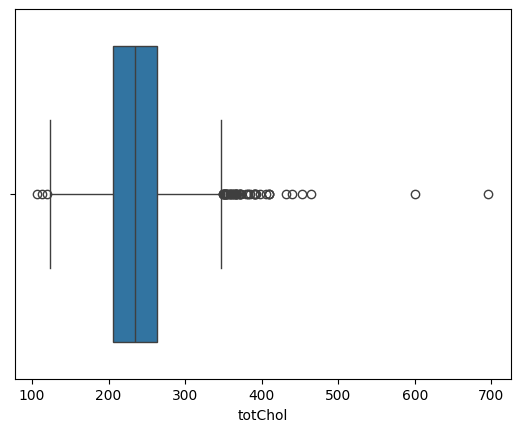

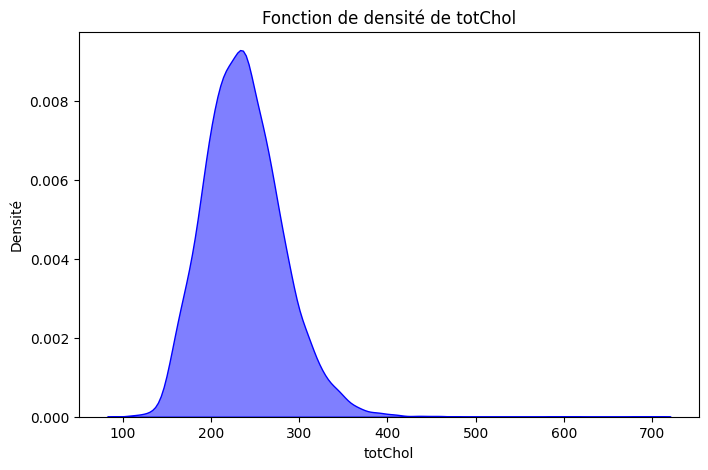

In [11]:
sns.boxplot(data=df, x='totChol')
variable ='totChol' 
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x=variable, fill=True, color='blue', alpha=0.5)
plt.title(f"Fonction de densité de {variable}")
plt.xlabel(variable)
plt.ylabel("Densité")
plt.show()




In [12]:
# Identification des données aberrantes - IQR
# Fonction pour détecter les outliers en utilisant l'IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Trouver les outliers pour la colonne 'PRICE'
outliers = detect_outliers_iqr(df,'totChol')
# Afficher les outliers
print("Outliers détectés:")
#print(outliers)
print(outliers['totChol'])
print(len(outliers))

Outliers détectés:
194     464.0
259     352.0
333     368.0
533     370.0
543     439.0
617     398.0
670     355.0
920     353.0
926     360.0
998     372.0
1103    352.0
1111    600.0
1150    392.0
1389    358.0
1447    391.0
1544    410.0
1610    356.0
1624    107.0
1691    372.0
1710    366.0
1870    365.0
1932    362.0
1937    410.0
2014    351.0
2024    390.0
2206    405.0
2208    359.0
2275    350.0
2349    380.0
2363    355.0
2368    390.0
2488    371.0
2525    113.0
2575    350.0
2602    354.0
2607    382.0
2671    364.0
2797    367.0
2972    352.0
2985    432.0
3056    351.0
3160    696.0
3165    363.0
3394    382.0
3418    361.0
3474    453.0
3532    352.0
3571    366.0
3806    410.0
3810    350.0
3816    391.0
3844    358.0
3916    373.0
4001    385.0
4003    366.0
4066    119.0
Name: totChol, dtype: float64
56


**On remarque qu'il y'a 56 valeurs abberantes pour tot chol**

**On va les remplacer par Nan**

In [13]:
def replace_outliers_with_mean(data, column):
    # Calcul des quartiles et des bornes
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    
    # Remplacement des valeurs aberrantes
    data[column] = data[column].apply(lambda x: np.nan if (x < lower_bound or x > upper_bound) else x)
    return data

# Application de la fonction à la colonne 'cigsPerDay'
df = replace_outliers_with_mean(df,'totChol')

# Vérification
print("Colonnes après traitement des outliers :")
print(df['totChol'].describe())

Colonnes après traitement des outliers :
count    4132.000000
mean      234.892788
std        40.854743
min       124.000000
25%       205.000000
50%       233.000000
75%       262.000000
max       347.000000
Name: totChol, dtype: float64


<Axes: xlabel='totChol'>

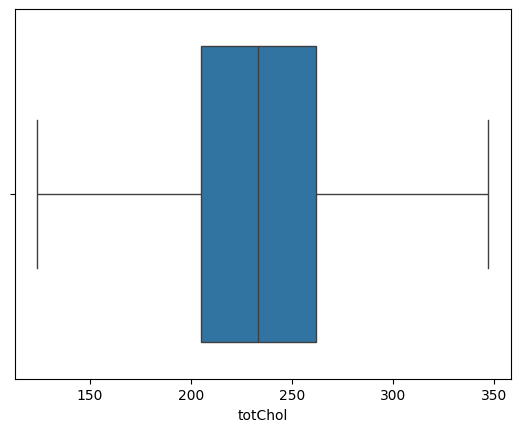

In [14]:
sns.boxplot(data=df, x='totChol')

**La variable SysBP**

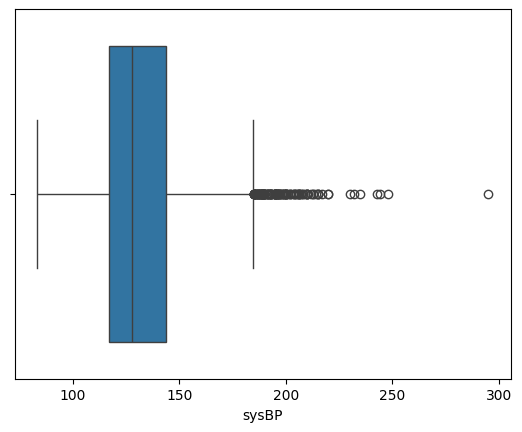

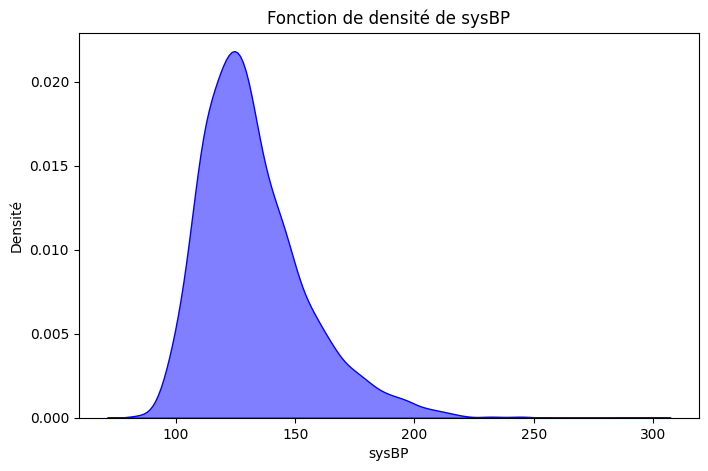

In [15]:
sns.boxplot(data=df, x='sysBP')
variable ='sysBP' 
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x=variable, fill=True, color='blue', alpha=0.5)
plt.title(f"Fonction de densité de {variable}")
plt.xlabel(variable)
plt.ylabel("Densité")
plt.show()

In [16]:
# Identification des données aberrantes - IQR
# Fonction pour détecter les outliers en utilisant l'IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Trouver les outliers pour la colonne 'PRICE'
outliers = detect_outliers_iqr(df,'sysBP')
# Afficher les outliers
print("Outliers détectés:")
#print(outliers)
print(outliers['sysBP'])
print(len(outliers))

Outliers détectés:
44      206.0
66      190.0
87      200.0
108     187.0
153     212.0
        ...  
4123    206.0
4173    210.0
4193    195.0
4222    188.0
4228    190.0
Name: sysBP, Length: 126, dtype: float64
126


In [17]:
def replace_outliers_with_mean(data, column):
    # Calcul des quartiles et des bornes
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    
    # Remplacement des valeurs aberrantes
    data[column] = data[column].apply(lambda x: np.nan if (x < lower_bound or x > upper_bound) else x)
    return data

# Application de la fonction à la colonne 'cigsPerDay'
df = replace_outliers_with_mean(df,'sysBP')

# Vérification
print("Colonnes après traitement des outliers :")
print(df['sysBP'].describe())

Colonnes après traitement des outliers :
count    4112.000000
mean      130.301921
std        18.762226
min        83.500000
25%       116.000000
50%       127.500000
75%       142.000000
max       184.500000
Name: sysBP, dtype: float64


<Axes: xlabel='sysBP'>

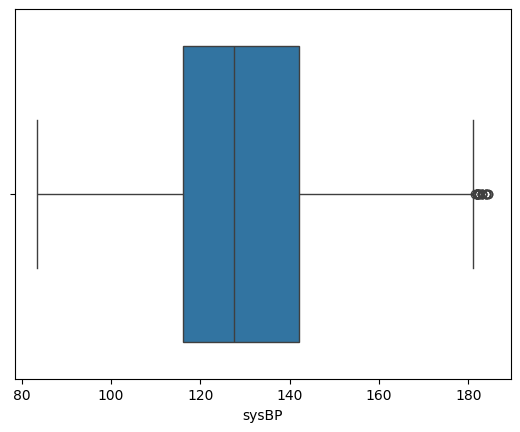

In [18]:
sns.boxplot(data=df, x='sysBP')

**diaBP**

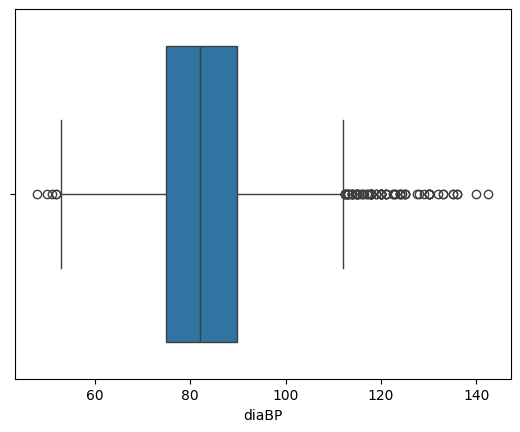

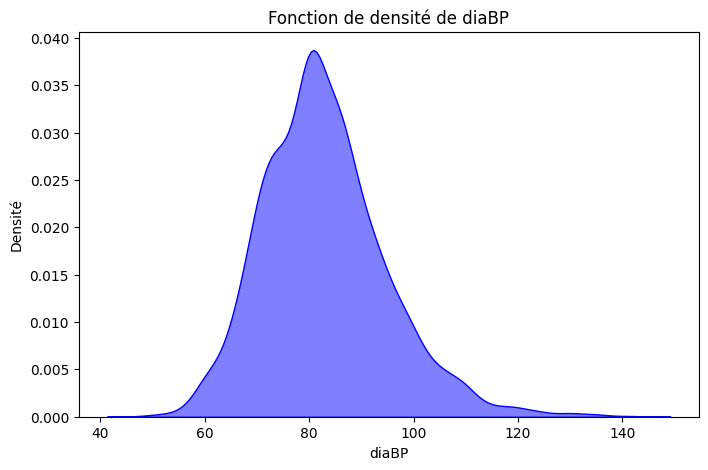

Outliers détectés:
28      121.0
46      114.0
158     124.5
249     122.5
407     123.0
        ...  
4075    125.0
4076    125.0
4123    116.0
4173    127.5
4228    130.0
Name: diaBP, Length: 81, dtype: float64
81
Colonnes après traitement des outliers :
count    4157.000000
mean       82.230936
std        10.726243
min        53.000000
25%        74.500000
50%        82.000000
75%        89.000000
max       112.000000
Name: diaBP, dtype: float64


<Axes: xlabel='diaBP'>

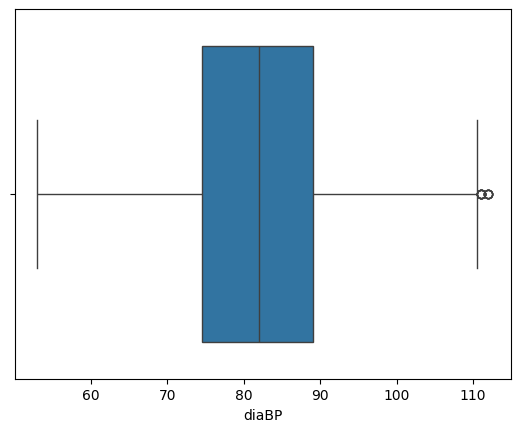

In [19]:

a='diaBP'

sns.boxplot(data=df, x=a)
variable =a
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x=variable, fill=True, color='blue', alpha=0.5)
plt.title(f"Fonction de densité de {variable}")
plt.xlabel(variable)
plt.ylabel("Densité")
plt.show()
# Identification des données aberrantes - IQR
# Fonction pour détecter les outliers en utilisant l'IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Trouver les outliers pour la colonne 'PRICE'
outliers = detect_outliers_iqr(df,a)
# Afficher les outliers
print("Outliers détectés:")
#print(outliers)
print(outliers[a])
print(len(outliers))
def replace_outliers_with_nan(data, column):
    # Calcul des quartiles et des bornes
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    
    # Remplacement des valeurs aberrantes
    data[column] = data[column].apply(lambda x: np.nan if (x < lower_bound or x > upper_bound) else x)
    return data

# Application de la fonction à la colonne 'cigsPerDay'
df = replace_outliers_with_nan(df,a)

# Vérification
print("Colonnes après traitement des outliers :")
print(df[a].describe())
sns.boxplot(data=df, x=a)



**BMI**

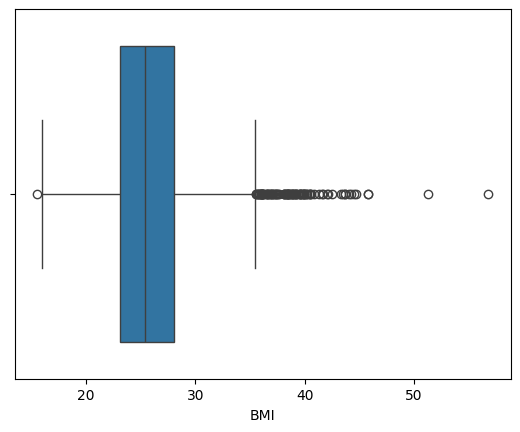

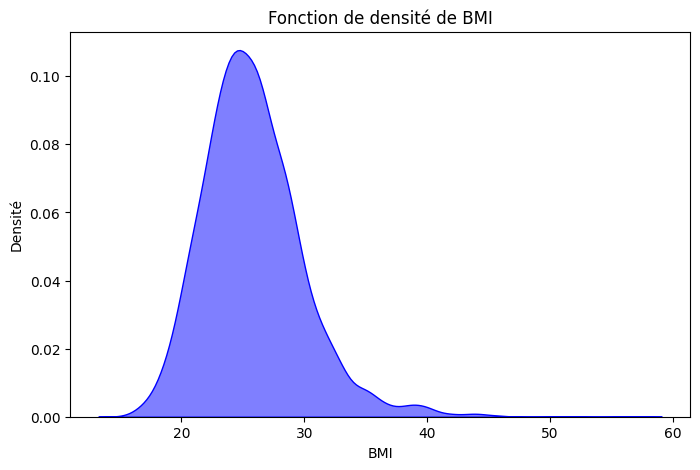

Outliers détectés:
35      38.53
37      40.11
78      45.80
87      38.46
108     40.52
        ...  
4001    41.66
4132    38.17
4190    36.07
4215    39.17
4228    43.67
Name: BMI, Length: 97, dtype: float64
97
Colonnes après traitement des outliers :
count    4122.000000
mean       25.492086
std         3.530546
min        15.960000
25%        23.030000
50%        25.290000
75%        27.860000
max        35.450000
Name: BMI, dtype: float64


<Axes: xlabel='BMI'>

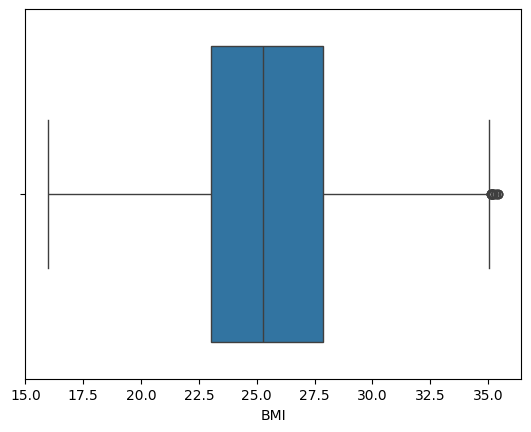

In [20]:

a='BMI'

sns.boxplot(data=df, x=a)
variable =a
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x=variable, fill=True, color='blue', alpha=0.5)
plt.title(f"Fonction de densité de {variable}")
plt.xlabel(variable)
plt.ylabel("Densité")
plt.show()
# Identification des données aberrantes - IQR
# Fonction pour détecter les outliers en utilisant l'IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Trouver les outliers pour la colonne 'PRICE'
outliers = detect_outliers_iqr(df,a)
# Afficher les outliers
print("Outliers détectés:")
#print(outliers)
print(outliers[a])
print(len(outliers))
def replace_outliers_with_nan(data, column):
    # Calcul des quartiles et des bornes
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    
    # Remplacement des valeurs aberrantes
    data[column] = data[column].apply(lambda x: np.nan if (x < lower_bound or x > upper_bound) else x)
    return data

# Application de la fonction à la colonne 'cigsPerDay'
df = replace_outliers_with_nan(df,a)

# Vérification
print("Colonnes après traitement des outliers :")
print(df[a].describe())
sns.boxplot(data=df, x=a)

**HeartRate**

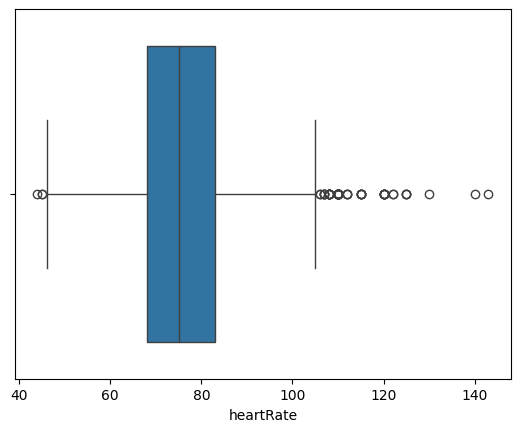

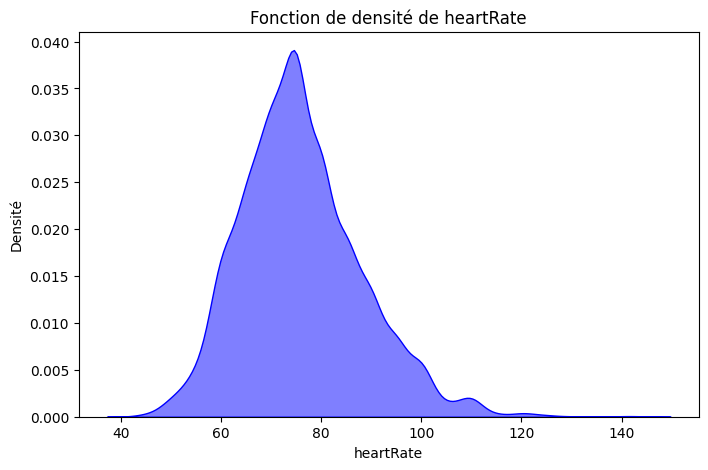

Outliers détectés:
162     110.0
270     110.0
339     140.0
358     130.0
382     108.0
        ...  
3957    110.0
3964    110.0
4053    125.0
4070    125.0
4164    112.0
Name: heartRate, Length: 76, dtype: float64
76
Colonnes après traitement des outliers :
count    4161.000000
mean       75.250661
std        11.007401
min        46.000000
25%        68.000000
50%        75.000000
75%        82.000000
max       105.000000
Name: heartRate, dtype: float64


<Axes: xlabel='heartRate'>

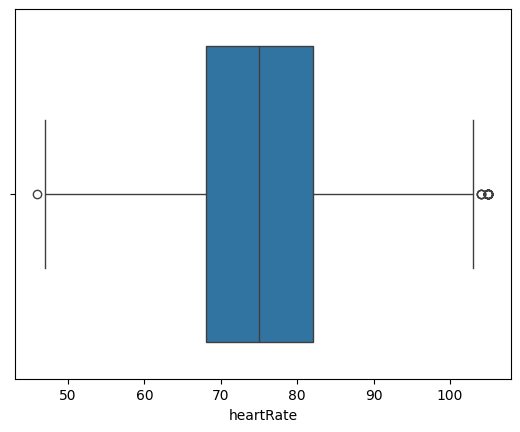

In [21]:

a='heartRate'

sns.boxplot(data=df, x=a)
variable =a
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x=variable, fill=True, color='blue', alpha=0.5)
plt.title(f"Fonction de densité de {variable}")
plt.xlabel(variable)
plt.ylabel("Densité")
plt.show()
# Identification des données aberrantes - IQR
# Fonction pour détecter les outliers en utilisant l'IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Trouver les outliers pour la colonne 'PRICE'
outliers = detect_outliers_iqr(df,a)
# Afficher les outliers
print("Outliers détectés:")
#print(outliers)
print(outliers[a])
print(len(outliers))
def replace_outliers_with_nan(data, column):
    # Calcul des quartiles et des bornes
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    
    # Remplacement des valeurs aberrantes
    data[column] = data[column].apply(lambda x: np.nan if (x < lower_bound or x > upper_bound) else x)
    return data

# Application de la fonction à la colonne 'cigsPerDay'
df = replace_outliers_with_nan(df,a)

# Vérification
print("Colonnes après traitement des outliers :")
print(df[a].describe())
sns.boxplot(data=df, x=a)

**Glucose**

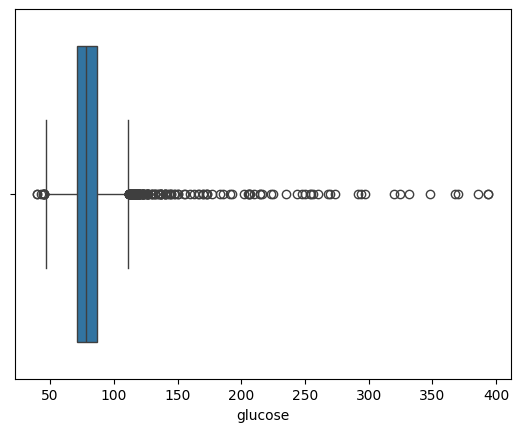

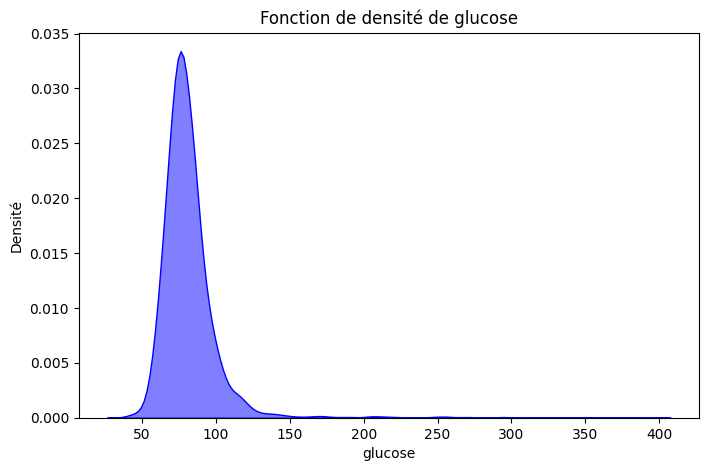

Outliers détectés:
22      113.0
37      225.0
44      215.0
65       45.0
66      202.0
        ...  
4115    118.0
4118    113.0
4203    120.0
4209    116.0
4228    260.0
Name: glucose, Length: 188, dtype: float64
188
Colonnes après traitement des outliers :
count    3662.000000
mean       78.489896
std        11.019651
min        47.000000
25%        71.000000
50%        77.000000
75%        85.000000
max       111.000000
Name: glucose, dtype: float64


<Axes: xlabel='glucose'>

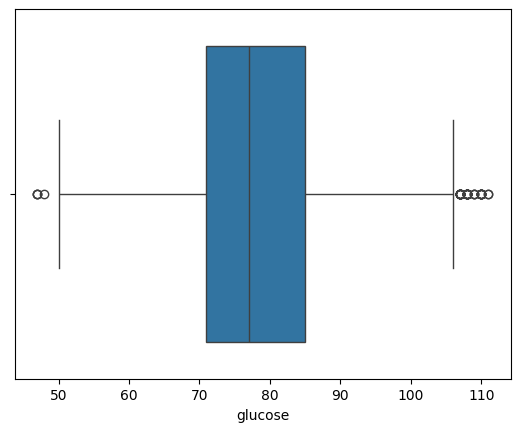

In [22]:

a='glucose'

sns.boxplot(data=df, x=a)
variable =a
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x=variable, fill=True, color='blue', alpha=0.5)
plt.title(f"Fonction de densité de {variable}")
plt.xlabel(variable)
plt.ylabel("Densité")
plt.show()
# Identification des données aberrantes - IQR
# Fonction pour détecter les outliers en utilisant l'IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Trouver les outliers pour la colonne 'PRICE'
outliers = detect_outliers_iqr(df,a)
# Afficher les outliers
print("Outliers détectés:")
#print(outliers)
print(outliers[a])
print(len(outliers))
def replace_outliers_with_nan(data, column):
    # Calcul des quartiles et des bornes
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    
    # Remplacement des valeurs aberrantes
    data[column] = data[column].apply(lambda x: np.nan if (x < lower_bound or x > upper_bound) else x)
    return data

# Application de la fonction à la colonne 'cigsPerDay'
df = replace_outliers_with_nan(df,a)

# Vérification
print("Colonnes après traitement des outliers :")
print(df[a].describe())
sns.boxplot(data=df, x=a)

**Data Missing values treatement**

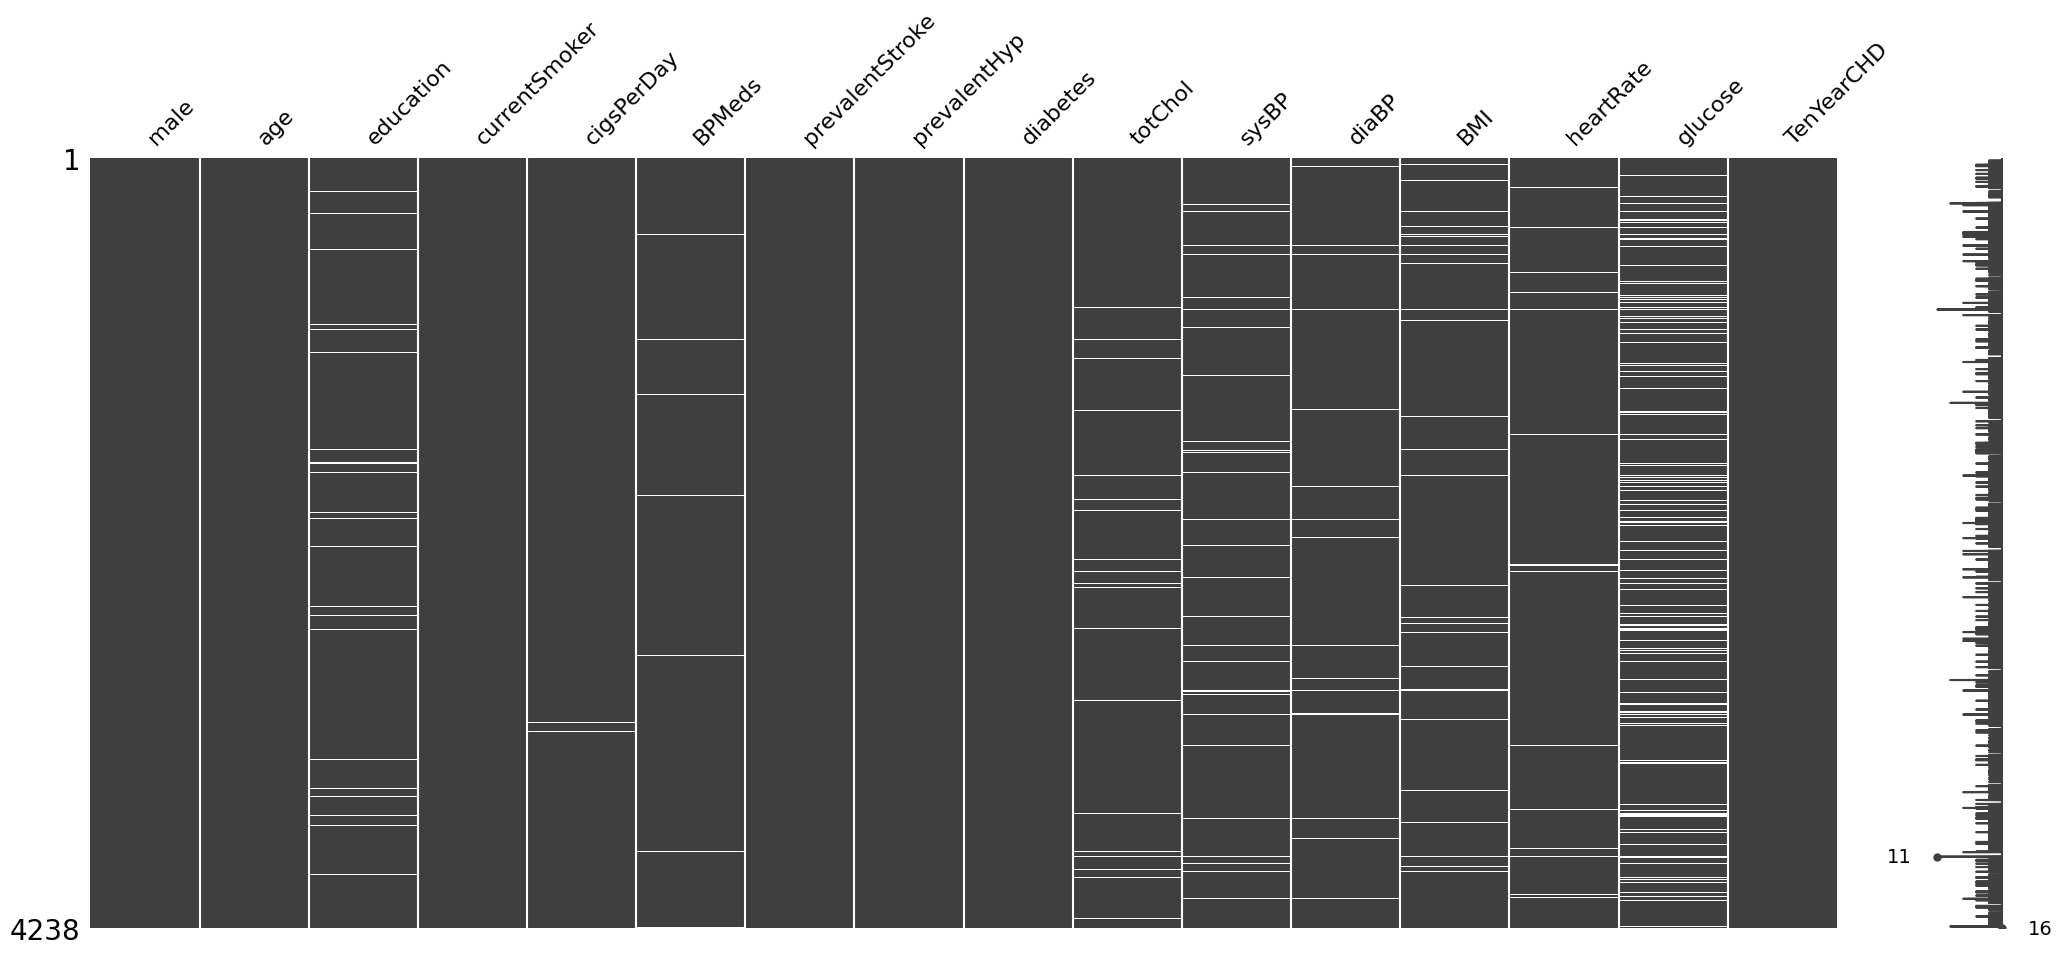

In [23]:
msno.matrix(df)
plt.show()

**Calcul du pourcentage des valeus manquantes pour chaque variable**

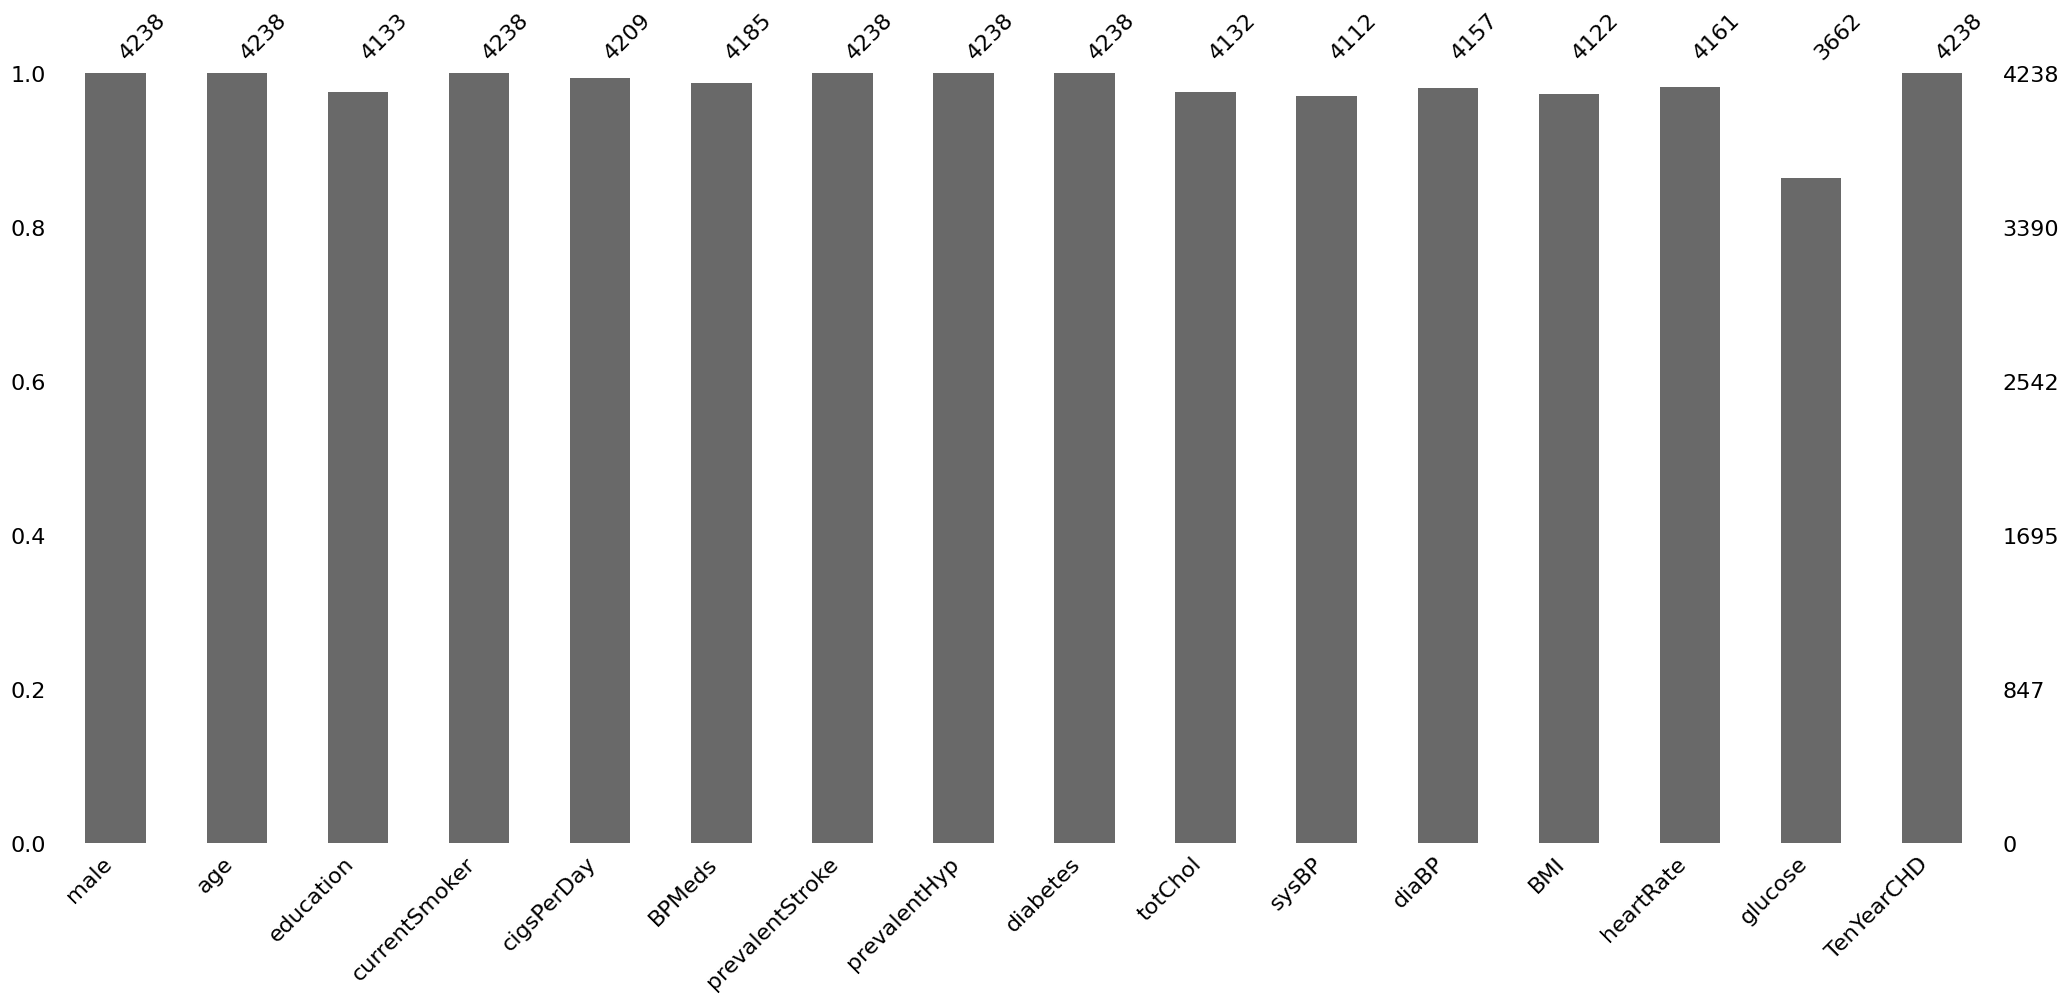

In [24]:
msno.bar(df)
plt.show()

In [25]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_table = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
print(missing_table)


                 Missing Values  Percentage
male                          0    0.000000
age                           0    0.000000
education                   105    2.477584
currentSmoker                 0    0.000000
cigsPerDay                   29    0.684285
BPMeds                       53    1.250590
prevalentStroke               0    0.000000
prevalentHyp                  0    0.000000
diabetes                      0    0.000000
totChol                     106    2.501180
sysBP                       126    2.973101
diaBP                        81    1.911279
BMI                         116    2.737140
heartRate                    77    1.816895
glucose                     576   13.591317
TenYearCHD                    0    0.000000


**Imputation de cigsPerday par la moyenne**

In [26]:
imputer_mean = SimpleImputer(strategy='mean')
df['cigsPerDay_imputed'] = imputer_mean.fit_transform(df[['cigsPerDay']])
df= df.drop(columns=['cigsPerDay'])  
# Vérifier les valeurs manquantes après imputation
missing_values_after = df.isnull().mean()

print("\nMissing Values After Treatment:\n", missing_values_after)


Missing Values After Treatment:
 male                  0.000000
age                   0.000000
education             0.024776
currentSmoker         0.000000
BPMeds                0.012506
prevalentStroke       0.000000
prevalentHyp          0.000000
diabetes              0.000000
totChol               0.025012
sysBP                 0.029731
diaBP                 0.019113
BMI                   0.027371
heartRate             0.018169
glucose               0.135913
TenYearCHD            0.000000
cigsPerDay_imputed    0.000000
dtype: float64


**Imputation des autres variables selon Missing At Random ou not At Random**

**Pour education est Missing not At Random donc on va utiliser iterativeimputer method**

In [27]:
imputer = IterativeImputer(max_iter=10, random_state=0, sample_posterior=True)

df_imputed = pd.DataFrame(imputer.fit_transform(df[['education']])).round().astype(int)
df_imputed.columns = ['education_imputed']
df = df.drop(columns=['education'])  
df = pd.concat([df, df_imputed], axis=1)
df.isnull().mean()


male                  0.000000
age                   0.000000
currentSmoker         0.000000
BPMeds                0.012506
prevalentStroke       0.000000
prevalentHyp          0.000000
diabetes              0.000000
totChol               0.025012
sysBP                 0.029731
diaBP                 0.019113
BMI                   0.027371
heartRate             0.018169
glucose               0.135913
TenYearCHD            0.000000
cigsPerDay_imputed    0.000000
education_imputed     0.000000
dtype: float64

**Les autres sont tous Missing At Random**

In [28]:

# Imputation par KNN Imputer
# KNN imputer avec 3 voisins pour plusieurs colonnes
imputer = KNNImputer(n_neighbors=7)
df[['totalchol_imputed', 'sysBP_imputed','diaBP_imputed','BMI_imputed','heartRate_imputed','glucose_imputed']] = imputer.fit_transform(df[['totChol', 'sysBP','diaBP','BMI','heartRate','glucose']])
  
df['BPMeds_imputed'] =imputer.fit_transform(df[['BPMeds']]).round().astype(int)
df= df.drop(columns=['BPMeds', 'totChol', 'sysBP','diaBP','BMI','heartRate','glucose'])

df.isnull().mean()

male                  0.0
age                   0.0
currentSmoker         0.0
prevalentStroke       0.0
prevalentHyp          0.0
diabetes              0.0
TenYearCHD            0.0
cigsPerDay_imputed    0.0
education_imputed     0.0
totalchol_imputed     0.0
sysBP_imputed         0.0
diaBP_imputed         0.0
BMI_imputed           0.0
heartRate_imputed     0.0
glucose_imputed       0.0
BPMeds_imputed        0.0
dtype: float64

**Standarisation de l'échelle**

In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

['male', 'age', 'currentSmoker', 'prevalentStroke', 'prevalentHyp',
       'diabetes', 'TenYearCHD', 'cigsPerDay_imputed', 'education_imputed',
       'totalchol_imputed', 'sysBP_imputed', 'diaBP_imputed', 'BMI_imputed',
       'heartRate_imputed', 'glucose_imputed', 'BPMeds_imputed']
# Identifier les types de variables
binary_features = ['male', 'currentSmoker', 'BPMeds_imputed', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD']
continuous_features = ['age', 'cigsPerDay_imputed', 'sysBP_imputed', 'diaBP_imputed', 'BMI_imputed','totalchol_imputed', 'sysBP_imputed', 'diaBP_imputed', 'BMI_imputed', 'sysBP_imputed','diaBP_imputed','heartRate_imputed', 'glucose_imputed']
categorical_features = ['education_imputed']

# Pipeline de transformation
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),  # Standardisation des variables continues
    ],
    remainder='passthrough'  # Conserve les variables binaires telles quelles
)

# Transformation des données
df1 = preprocessor.fit_transform(df)
print(df1)

[[-1.23495068 -0.76660675 -1.31800671 ...  0.          0.
   0.        ]
 [-0.41825733 -0.76660675 -0.52066885 ...  0.          0.
   0.        ]
 [-0.18491638  0.96479731 -0.17515577 ...  0.          0.
   0.        ]
 ...
 [-0.18491638  0.96479731  0.01088973 ...  0.          0.
   0.        ]
 [-0.65159829  0.53194629 -0.22831163 ...  0.          0.
   0.        ]
 [ 0.28176554 -0.76660675  0.14377937 ...  0.          0.
   0.        ]]


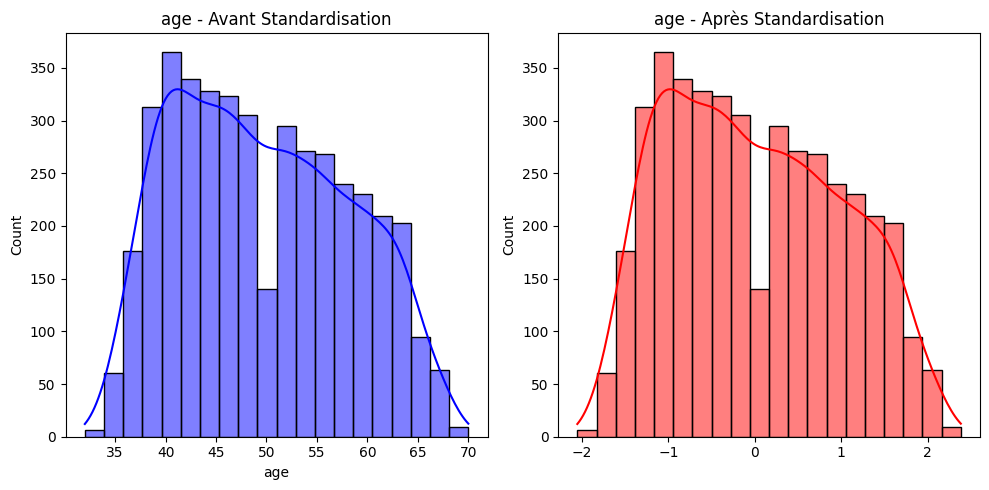

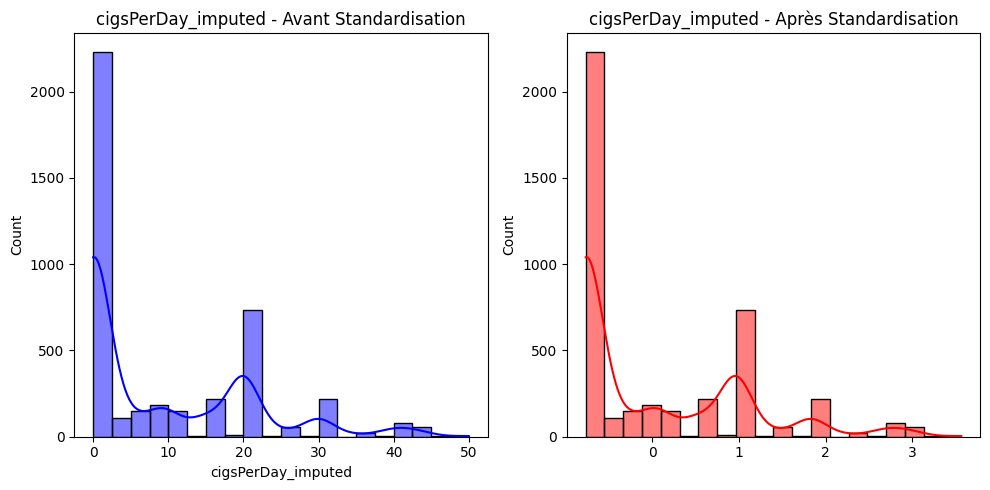

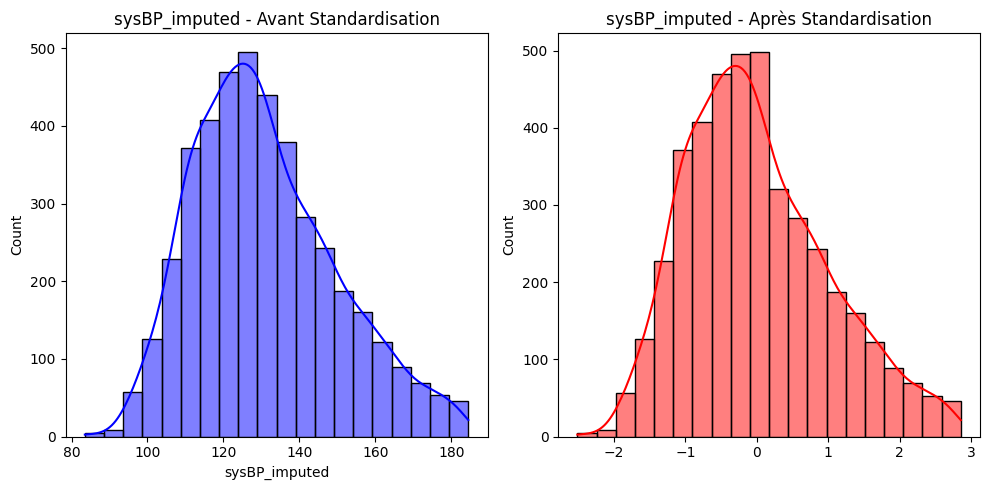

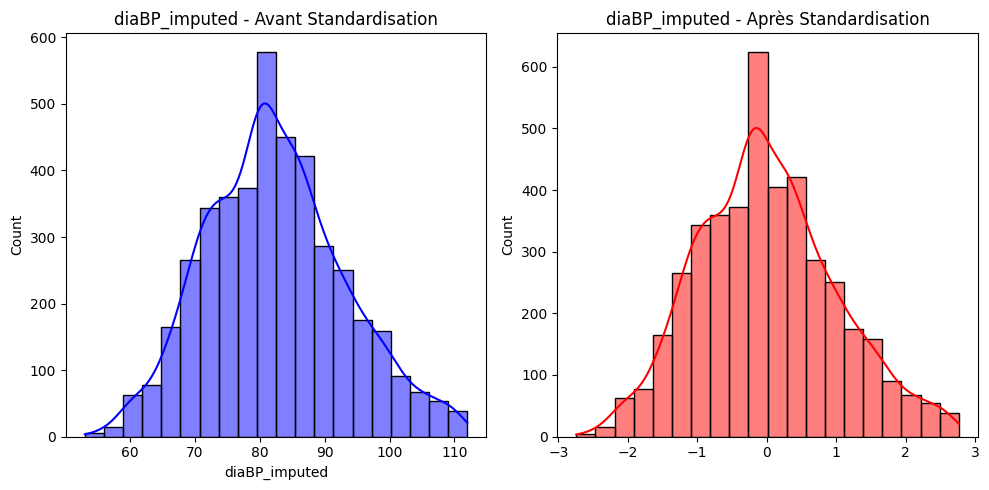

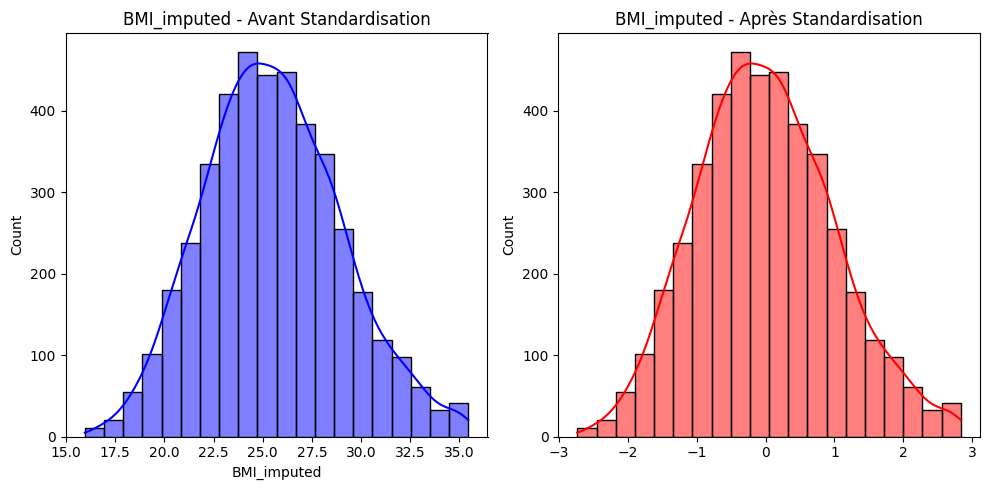

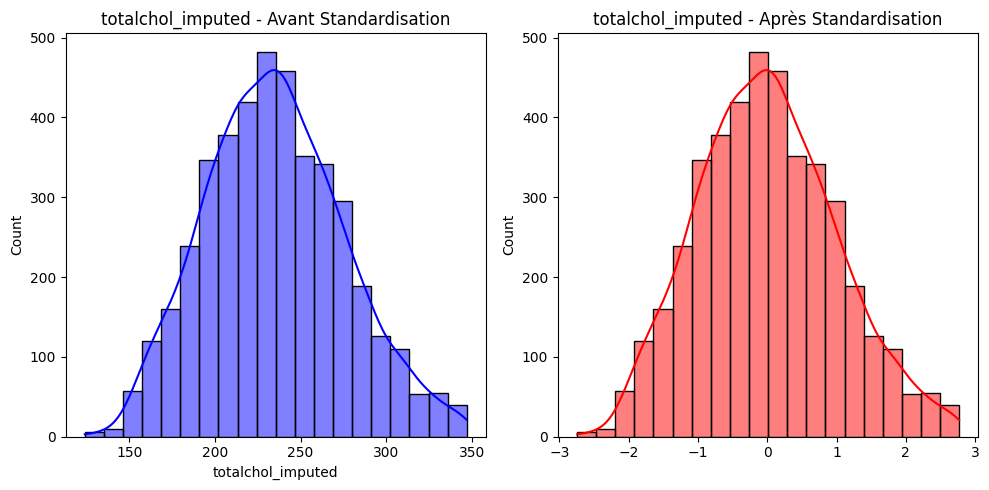

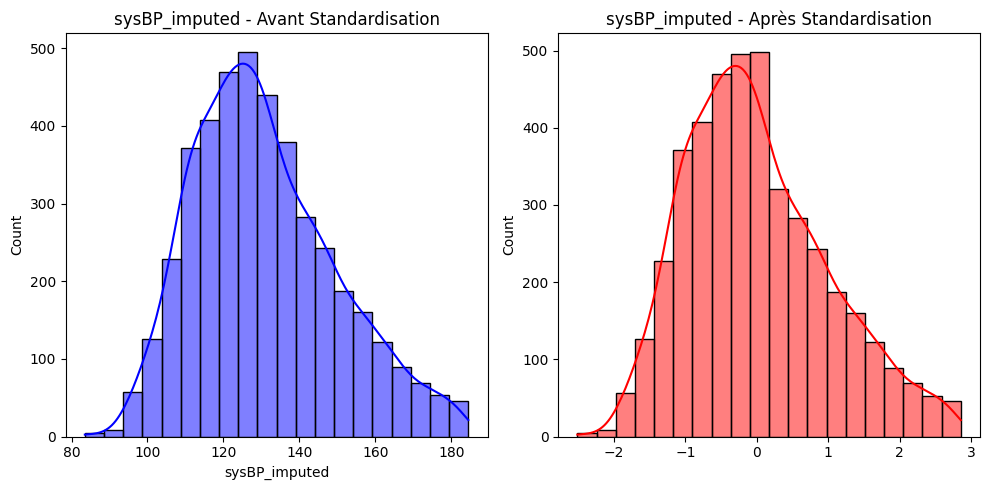

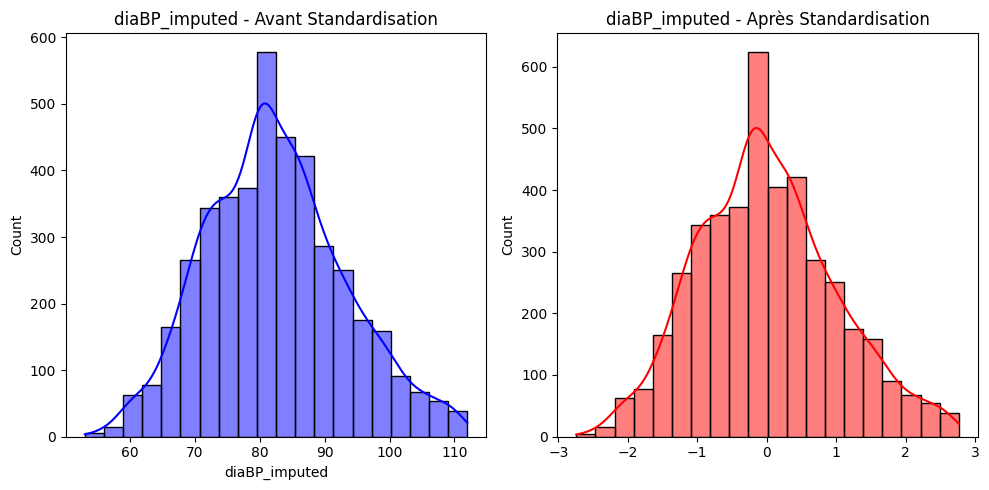

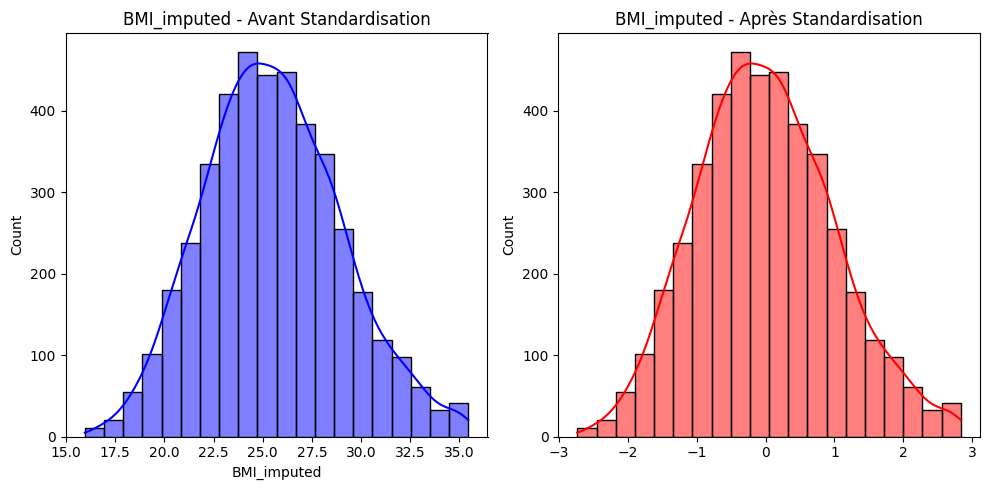

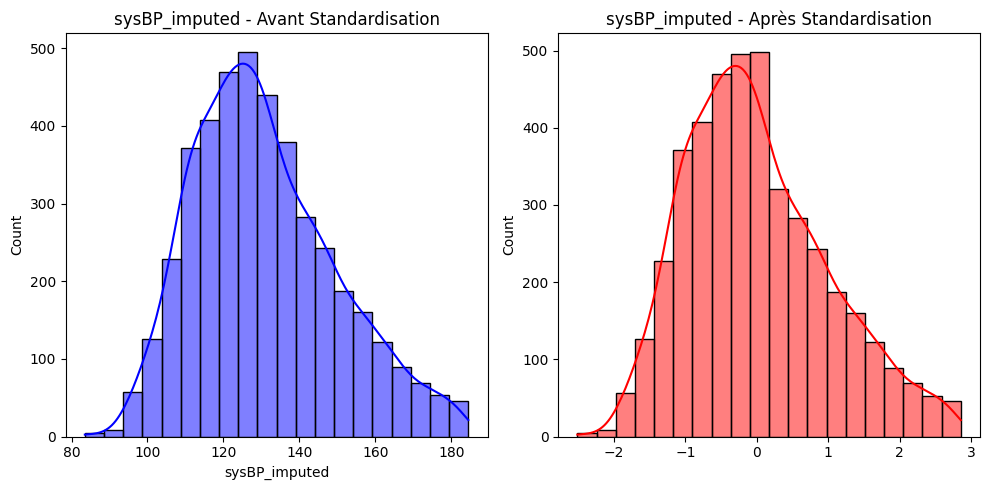

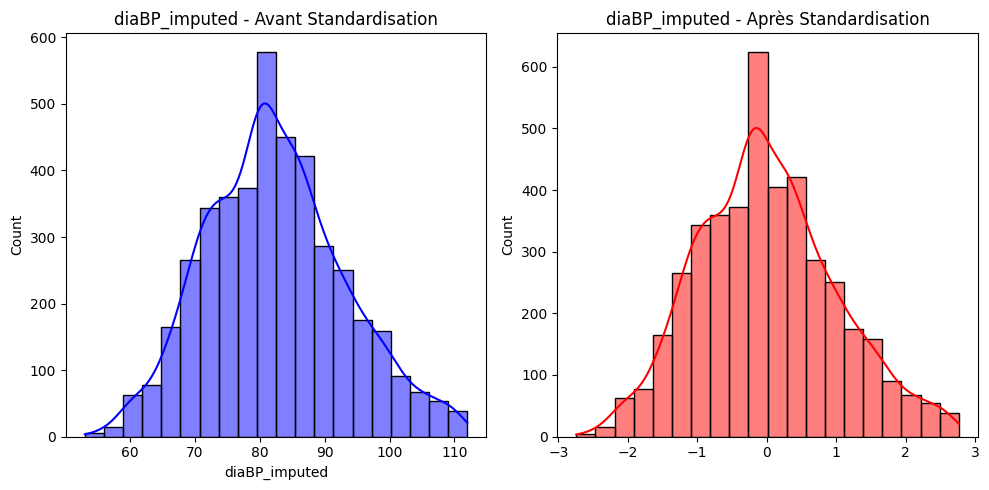

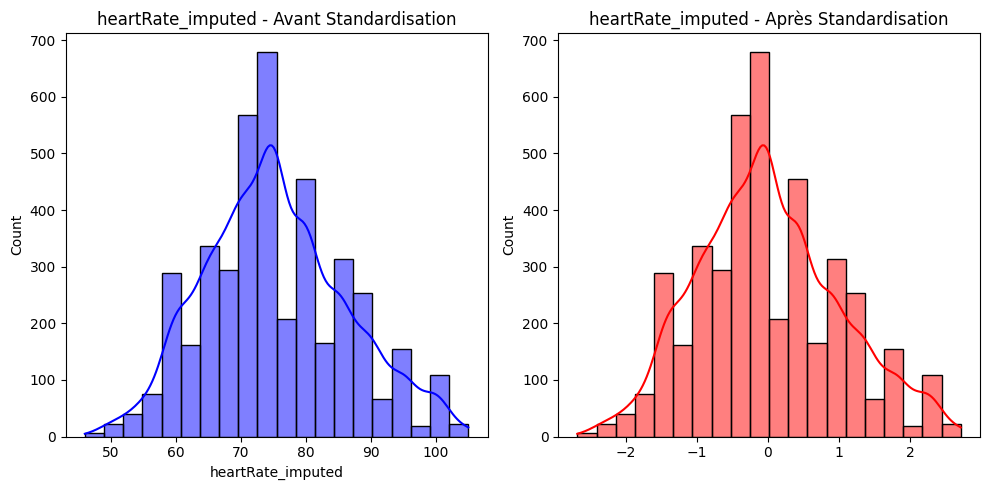

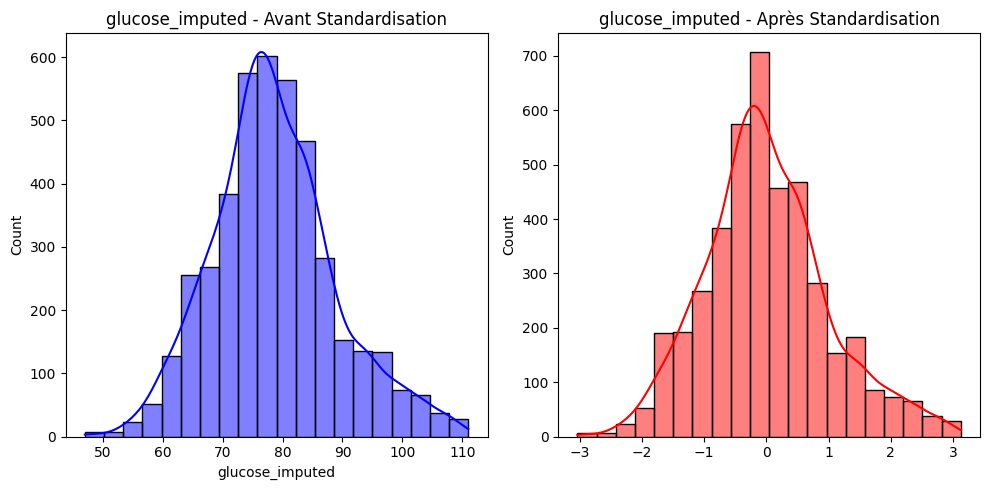

In [30]:
# Visualisation pour chaque variable continue avant et après standardisation
for var in continuous_features:
    plt.figure(figsize=(10, 5))
    
    # Avant standardisation
    plt.subplot(1, 2, 1)
    sns.histplot(df[var], kde=True, bins=20, color='blue')
    plt.title(f'{var} - Avant Standardisation')

    # Après standardisation
    plt.subplot(1, 2, 2)
    idx = continuous_features.index(var)
    sns.histplot(df1[:, idx], kde=True, bins=20, color='red')
    plt.title(f'{var} - Après Standardisation')


    plt.tight_layout()
    plt.show()

**Analyse univarié**

**Les variables quantitatives**

<Axes: >

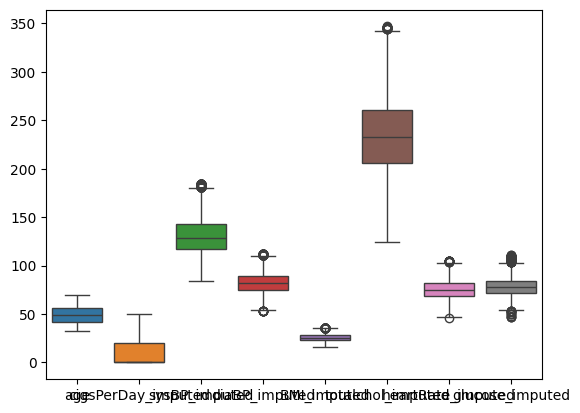

In [31]:
Quantitative= ['age', 'cigsPerDay_imputed', 'sysBP_imputed', 'diaBP_imputed', 'BMI_imputed','totalchol_imputed', 'sysBP_imputed', 'diaBP_imputed', 'BMI_imputed', 'sysBP_imputed','diaBP_imputed','heartRate_imputed', 'glucose_imputed']
sns.boxplot(data=df[Quantitative])

**Test de la normalité pour les variables quantitatives**

In [41]:
# Analyse de la normalité
# Création d'un histogramme et d'un test de normalité pour chaque variable
import scipy.stats as stats
for column in Quantitative:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=df1, x=column, kde=True)
    plt.title(f"Histogramme de la variable {column}")
    plt.show()
    statistic, p_value = stats.normaltest(df1[column])
    if p_value < 0.05:
        print(f"La variable {column} ne suit pas une loi normale (p-value={p_value})")
    else:
        print(f"La variable {column} suit  une loi normale (p-value={p_value})")
    
    

TypeError: Data source must be a DataFrame or Mapping, not <class 'numpy.ndarray'>.

<Figure size 800x600 with 0 Axes>

**Pour les variables qualitatives**

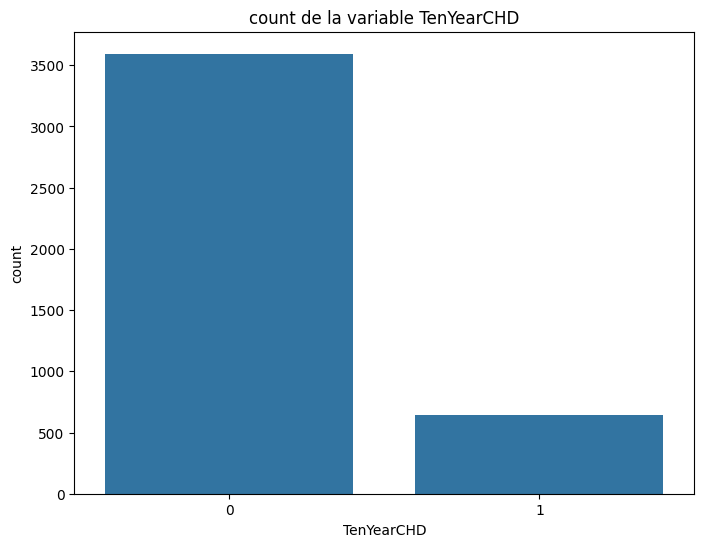

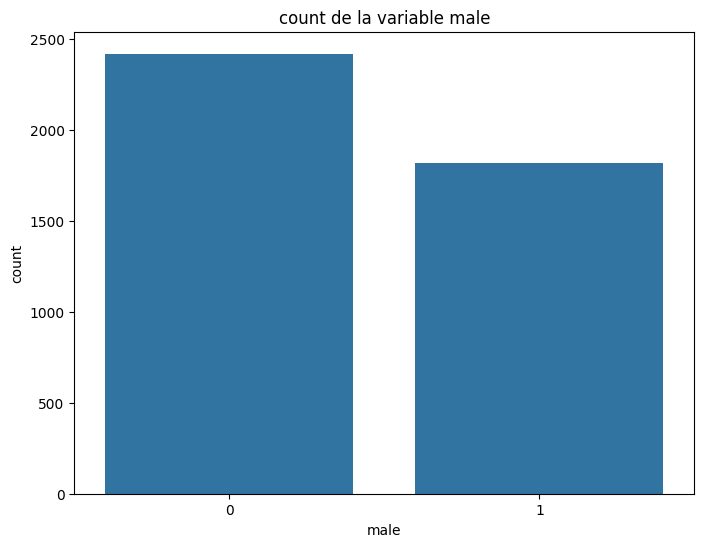

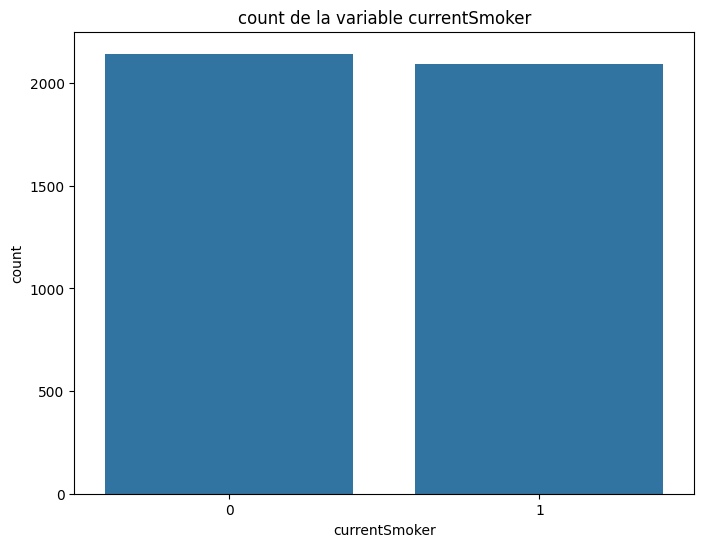

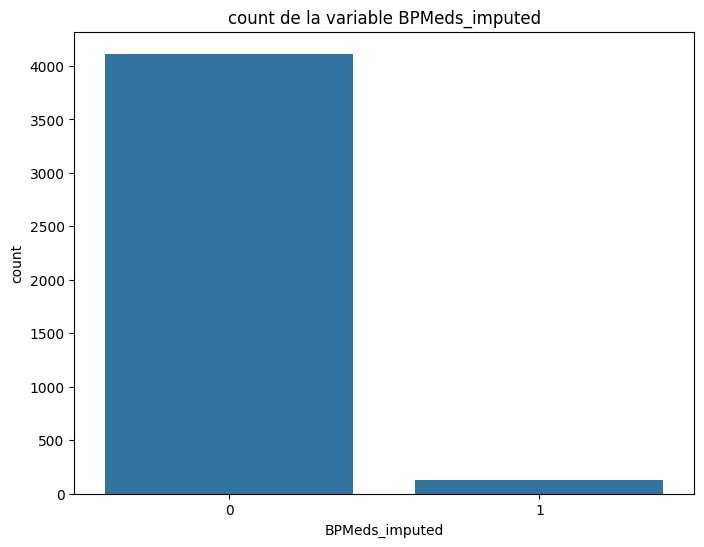

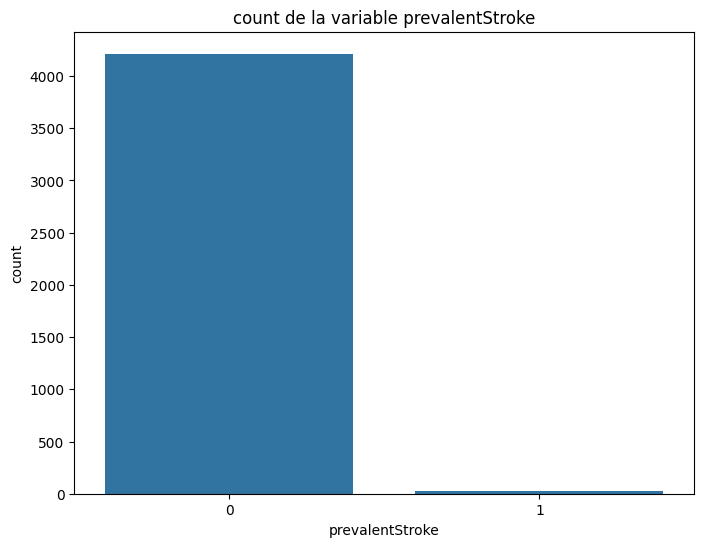

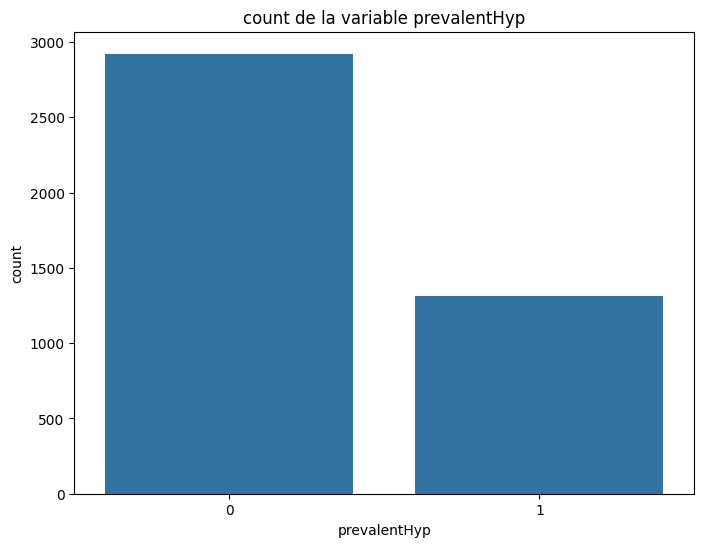

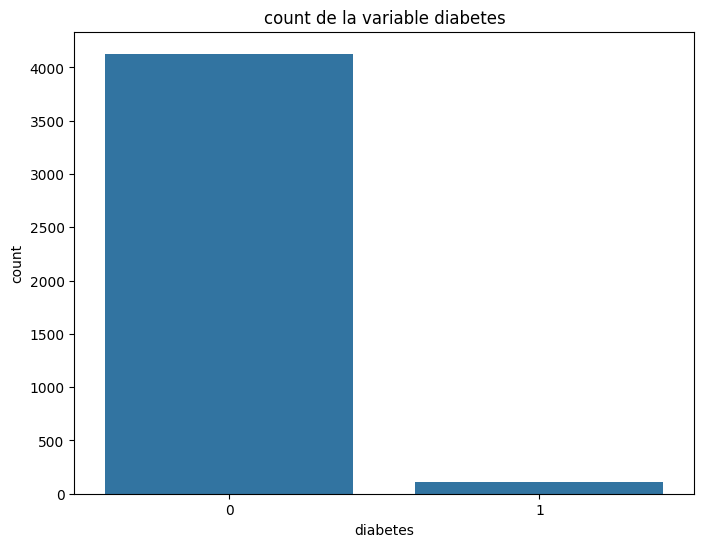

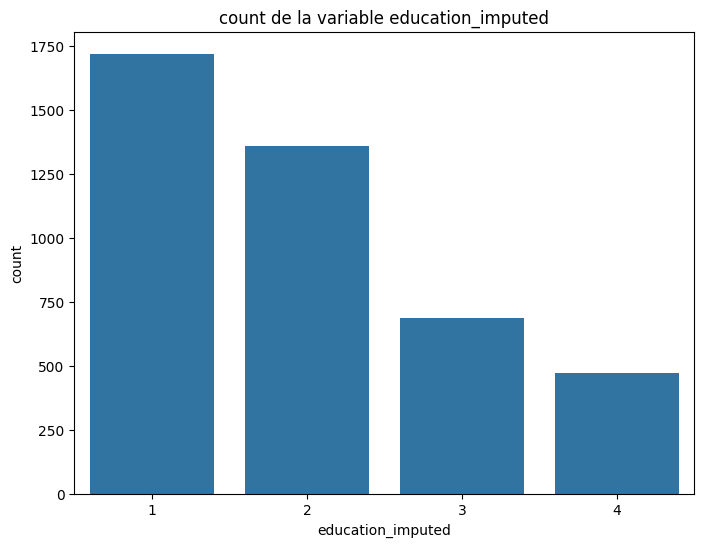

In [33]:
Qualitatifs=['TenYearCHD','male', 'currentSmoker', 'BPMeds_imputed', 'prevalentStroke', 'prevalentHyp', 'diabetes','education_imputed']

for column in Qualitatifs:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=df, x=column)
    plt.title(f"count de la variable {column}")
    plt.show()


**La distribution des variables en fonction de la variable cible TenYearCHD**

C:\Users\User\AppData\Local\Temp\ipykernel_35412\1576167019.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TenYearCHD', y=col, data=df, palette='Set2', ax=ax)
C:\Users\User\AppData\Local\Temp\ipykernel_35412\1576167019.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TenYearCHD', y=col, data=df, palette='Set2', ax=ax)
C:\Users\User\AppData\Local\Temp\ipykernel_35412\1576167019.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TenYearCHD', y=col, data=df, palette='Set2', ax=ax)
C:\Users\User\AppData\Local\Temp\ipykernel_

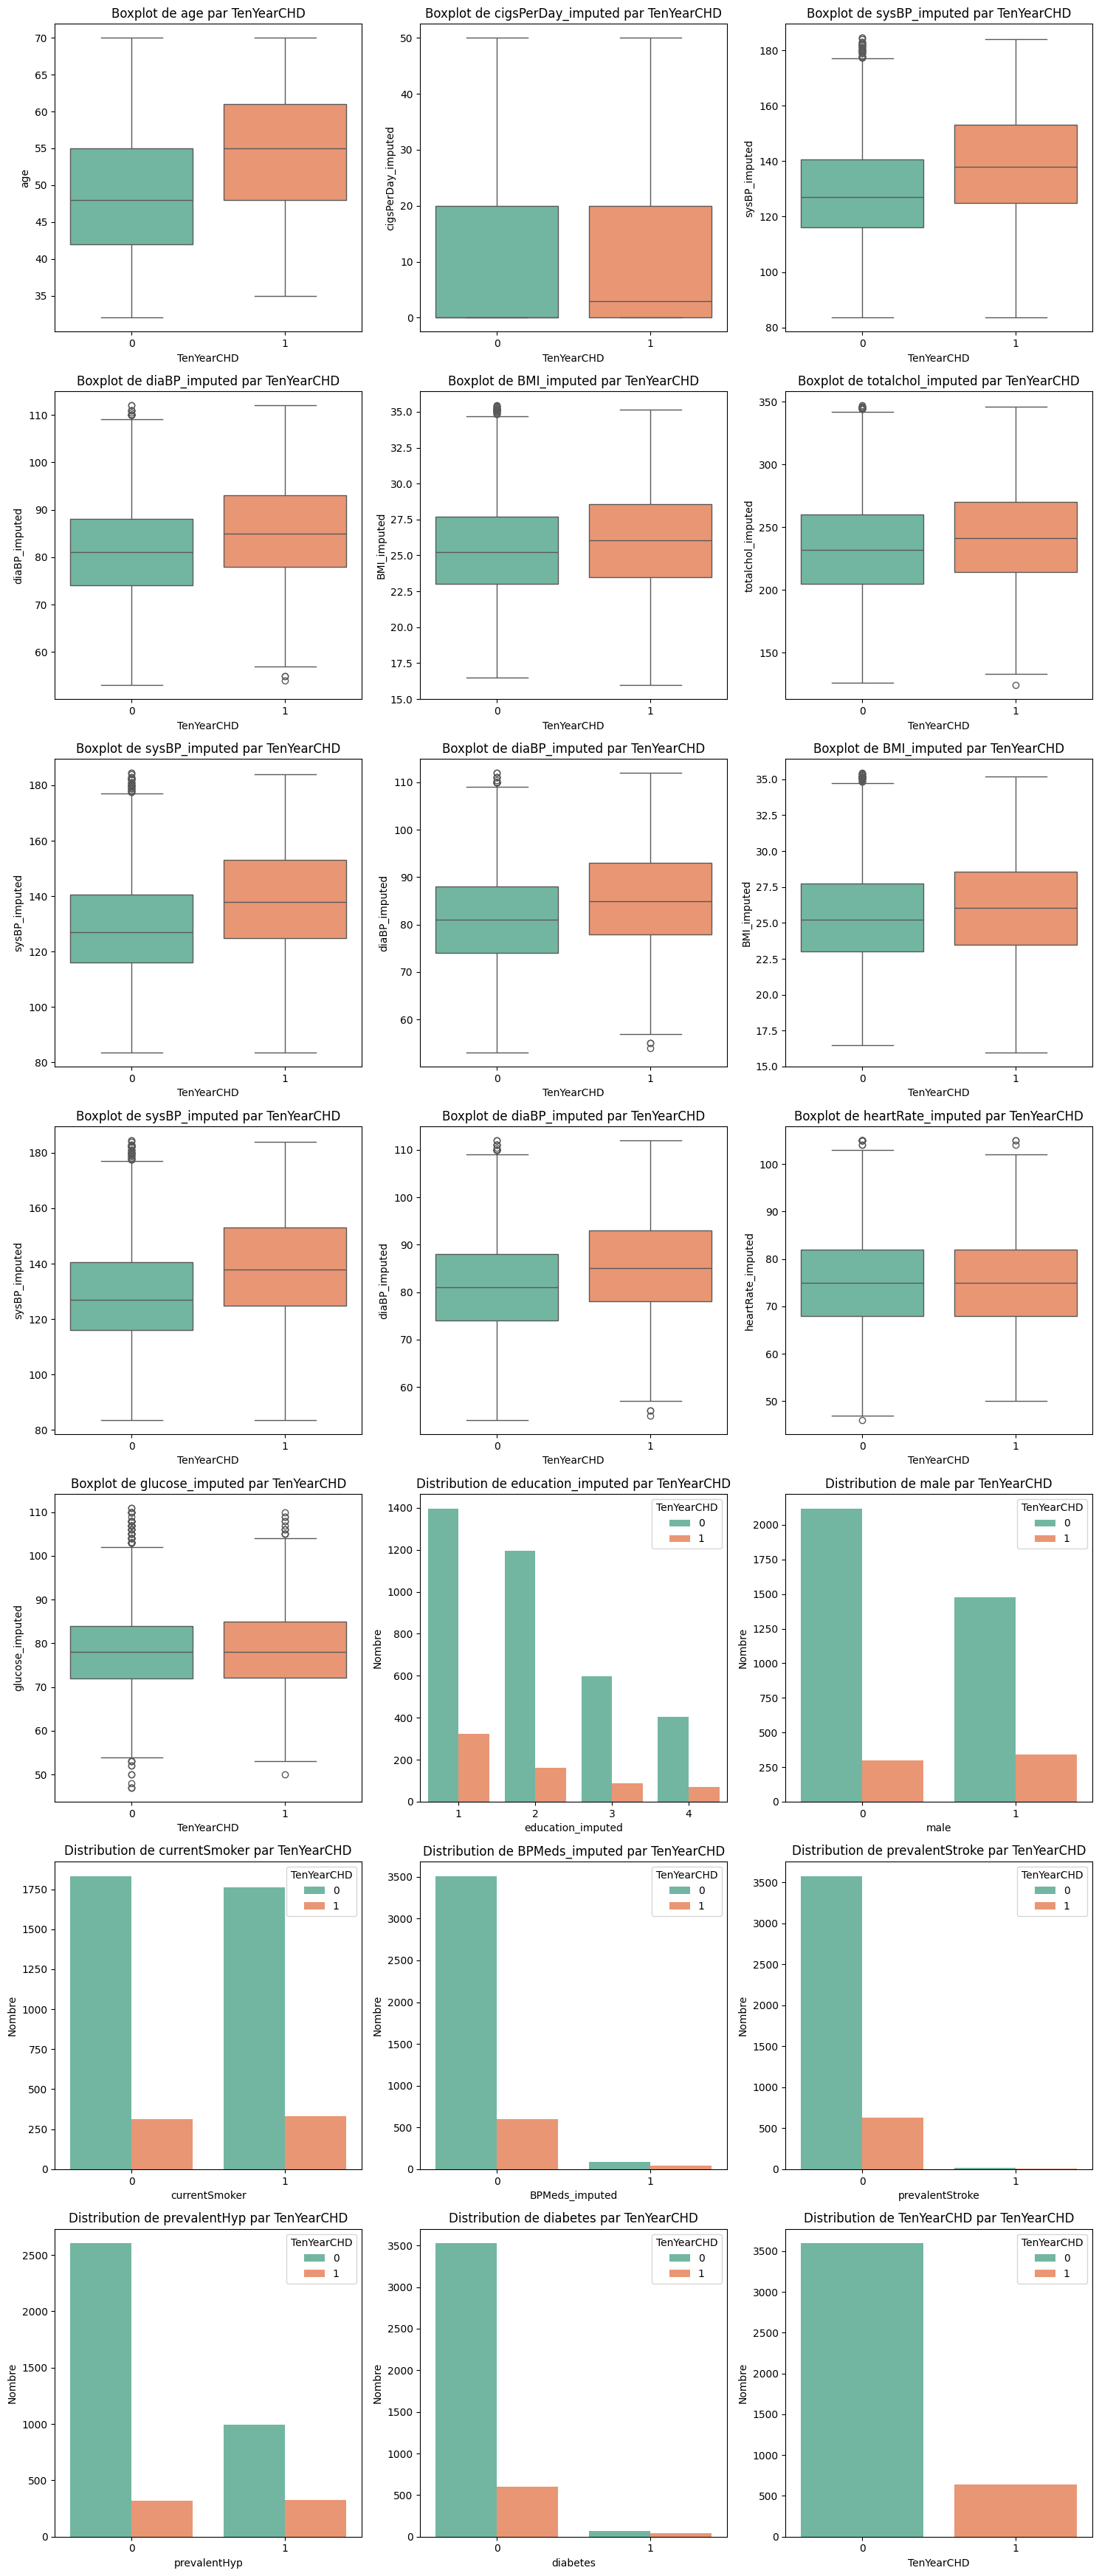

In [34]:
import math

# Nombre de colonnes pour les subplots (ajustez selon vos besoins)
n_cols = 3
n_rows = math.ceil(len(continuous_features) / n_cols) + len(categorical_features + binary_features) // n_cols

# Créer une figure avec des subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))

# Pour les variables continues
for i, col in enumerate(continuous_features):
    ax = axes[i // n_cols, i % n_cols]
    sns.boxplot(x='TenYearCHD', y=col, data=df, palette='Set2', ax=ax)
    ax.set_title(f"Boxplot de {col} par TenYearCHD")
    ax.set_xlabel("TenYearCHD")
    ax.set_ylabel(col)

# Pour les variables binaires et catégoriques
for i, col in enumerate(categorical_features + binary_features):
    ax = axes[(i + len(continuous_features)) // n_cols, (i + len(continuous_features)) % n_cols]
    sns.countplot(x=col, hue='TenYearCHD', data=df, palette='Set2', ax=ax)
    ax.set_title(f"Distribution de {col} par TenYearCHD")
    ax.set_xlabel(col)
    ax.set_ylabel("Nombre")
    ax.legend(title="TenYearCHD", loc='upper right')

# Ajuster les espaces entre les subplots
plt.tight_layout()
plt.show()


**Analyse bivariée**

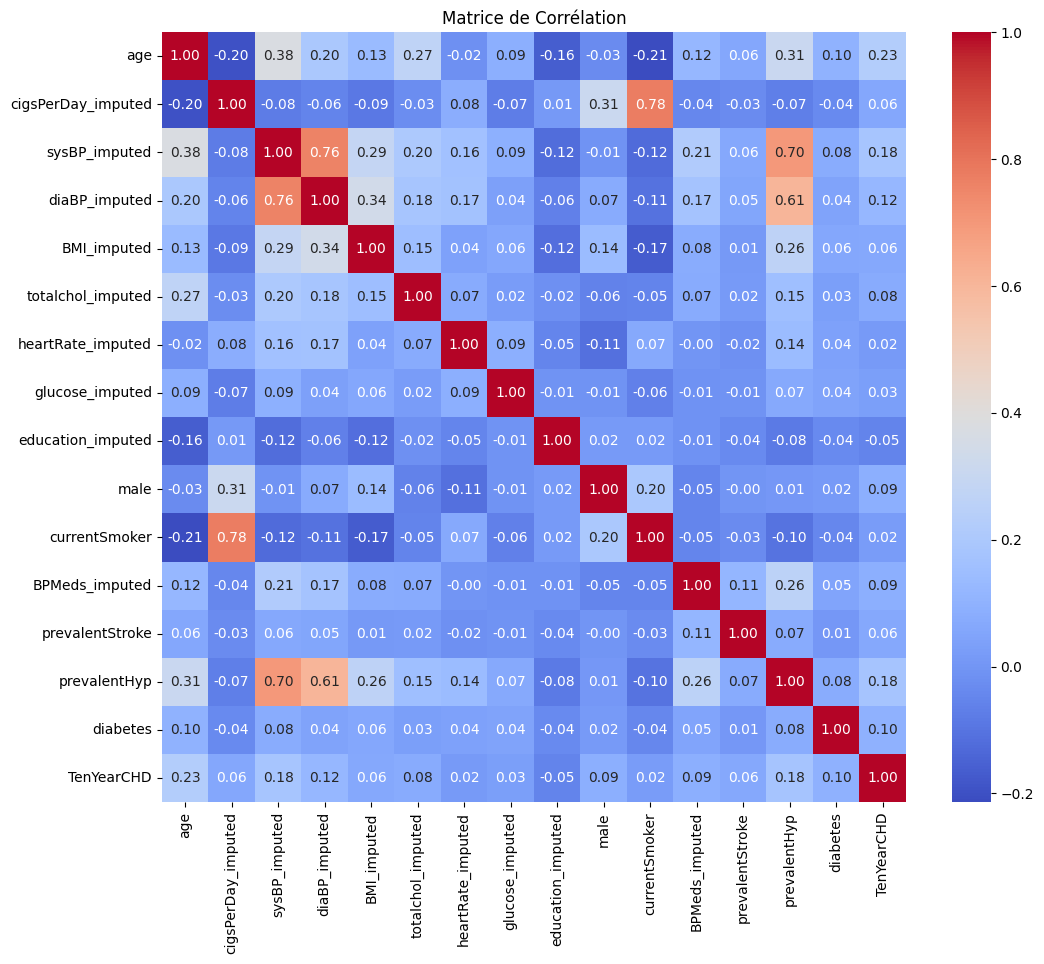

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Combiner toutes les colonnes uniques
all_features = continuous_features + categorical_features + binary_features
df = pd.DataFrame(df, columns=all_features)

# Supprimer les colonnes dupliquées s'il y en a
df= df.loc[:, ~df.columns.duplicated()]

# Calculer la matrice de corrélation
correlation_matrix = df.corr()

# Afficher la matrice sous forme de heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice de Corrélation")
plt.show()



**Model:LogisticRegression**

**Feature Selection**

In [36]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Séparer X et y
X = df.drop(columns=['TenYearCHD'])
y = df['TenYearCHD']

# Appliquer SMOTE pour équilibrer les classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Entraîner sur les données équilibrées
clf = LogisticRegression(solver='liblinear', max_iter=1000)
sfs = SFS(clf, k_features='best', forward=True, floating=False, scoring='roc_auc', cv=5)
sfs = sfs.fit(X_resampled, y_resampled)

# Afficher les résultats
print("Forward Selection: \nMeilleures caractéristiques:", list(X.columns[list(sfs.k_feature_idx_)]),
      "\nMeilleur score:", sfs.k_score_)


Forward Selection: 
Meilleures caractéristiques: ['age', 'cigsPerDay_imputed', 'sysBP_imputed', 'diaBP_imputed', 'heartRate_imputed', 'education_imputed', 'male', 'currentSmoker', 'prevalentHyp'] 
Meilleur score: 0.7340773905461928


**Interprétation du modéle**

In [37]:
from imblearn.over_sampling import SMOTE


X = df.drop(columns=['TenYearCHD'])  
y = df['TenYearCHD']
smote=SMOTE(sampling_strategy='minority') 
x,y=smote.fit_resample(X,y)
y.value_counts()
XX=x[['age', 'cigsPerDay_imputed', 'diaBP_imputed', 'BMI_imputed', 'totalchol_imputed', 'heartRate_imputed', 'glucose_imputed', 'education_imputed', 'currentSmoker', 'BPMeds_imputed', 'prevalentHyp', 'diabetes']]

In [38]:
import statsmodels.api as sm



X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.3, random_state=42)

# Créer et ajuster le modèle de régression logistique
model = sm.Logit(y_train, X_train)
result = model.fit()

# Afficher le résumé du modèle
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.609943
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 5031
Model:                          Logit   Df Residuals:                     5019
Method:                           MLE   Df Model:                           11
Date:                Fri, 29 Nov 2024   Pseudo R-squ.:                  0.1200
Time:                        22:55:51   Log-Likelihood:                -3068.6
converged:                       True   LL-Null:                       -3487.2
Covariance Type:            nonrobust   LLR p-value:                2.041e-172
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
age                    0.0561      0.004     13.908      0.000       0.048       0.064
cigsP

Accuracy: 0.66
Rapport de classification:
Matrice de confusion:
              precision    recall  f1-score   support

           0       0.68      0.63      0.65      1090
           1       0.65      0.70      0.67      1067

    accuracy                           0.66      2157
   macro avg       0.66      0.66      0.66      2157
weighted avg       0.66      0.66      0.66      2157



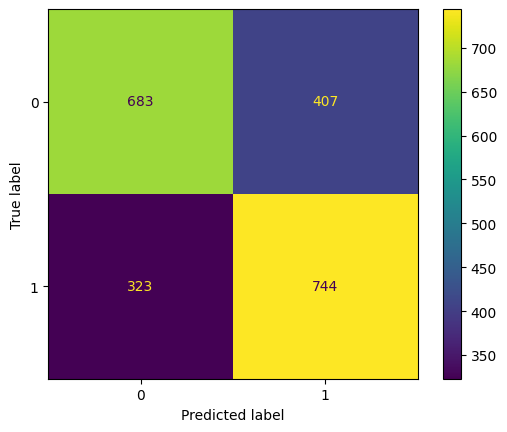

In [39]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prédictions sur l'ensemble de test
y_pred = result.predict(X_test)  # Prédictions des probabilités
y_pred_class = (y_pred > 0.5).astype(int)  # Conversion des probabilités en classes (0 ou 1)



cm1 = confusion_matrix(y_test, y_pred_class)
ConfusionMatrixDisplay(cm1).plot()



# Évaluation du modèle
accuracy = accuracy_score(y_test, y_pred_class)
class_report = classification_report(y_test, y_pred_class)

# Affichage des résultats
print(f"Accuracy: {accuracy:.2f}")
print("Rapport de classification:")
print("Matrice de confusion:")
print(class_report)


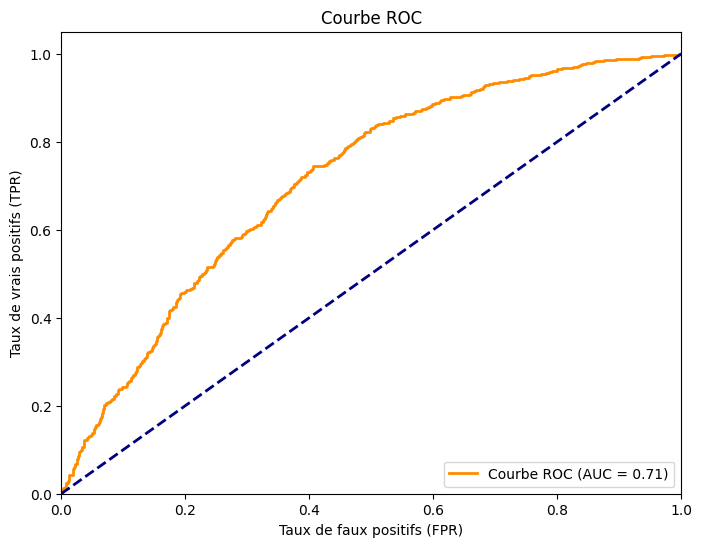

AUC: 0.7133453135344746


In [40]:
from sklearn.metrics import roc_curve, auc

# Calcul des taux de vrais positifs (TPR) et de faux positifs (FPR)
y_pred_proba = result.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcul de l'AUC
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

# Affichage de l'AUC
print(f"AUC: {roc_auc}")